Mounted at /content/drive



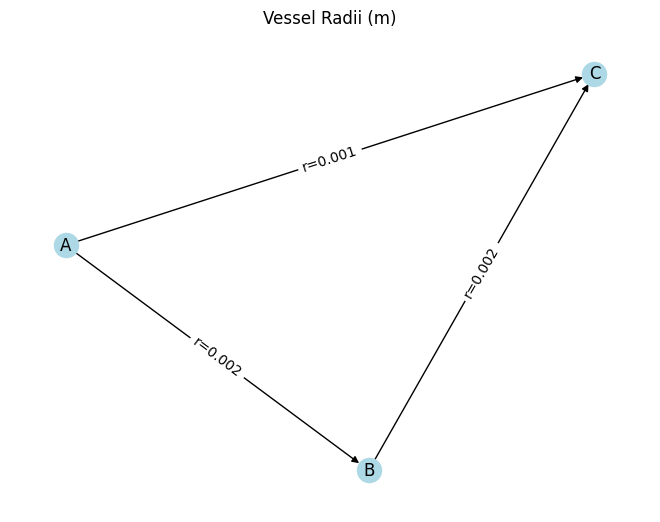


Node Pressures:
A: 100.00 mmHg
C: 0.00 mmHg
B: 50.00 mmHg

Flow between nodes:
A → B: 89.759790 μL/s
A → C: 7.479983 μL/s
B → C: 89.759790 μL/s


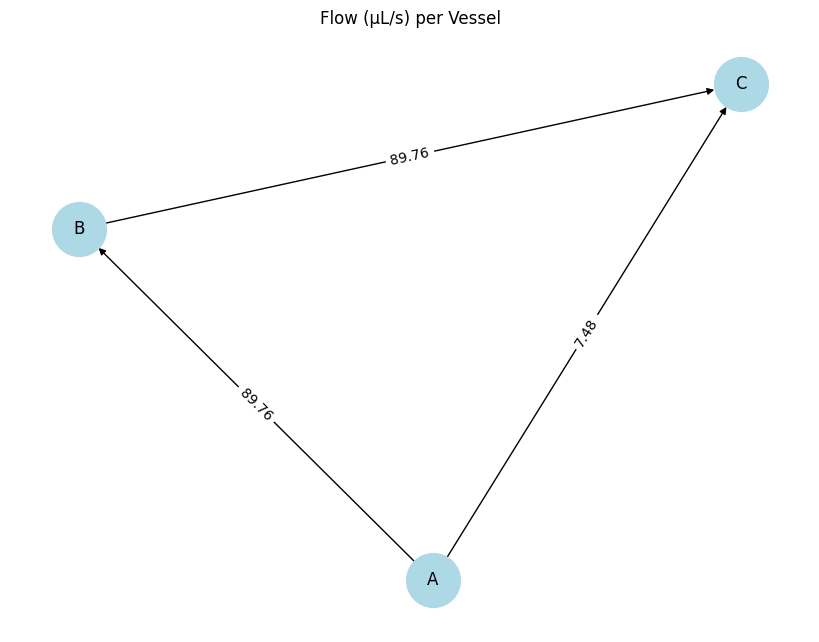

---------------------additional nodes---------------------
------------------------------------------------------------------------
Scenario: normal
Node Pressures (mmHg):
  IN: 100.00
  P1: 99.01
  P2: 97.91
  P3: 98.22
  C1: 96.02
  C2: 94.08
  C3: 94.39
  V1: 12.45
  V2: 12.76
  OUT: 0.00
Edge Flows (μL/s):
  IN → P1: 28847.092
  P1 → P2: 19306.997
  P1 → P3: 9540.094
  P2 → C1: 9766.708
  P2 → C2: 9540.289
  P3 → C3: 9540.094
  C1 → V1: 9766.708
  C2 → V1: 9540.289
  C3 → V2: 9540.094
  V1 → OUT: 19306.997
  V2 → OUT: 9540.094
Total inflow at IN:   28847.09 μL/s
Total outflow at OUT: 28847.09 μL/s


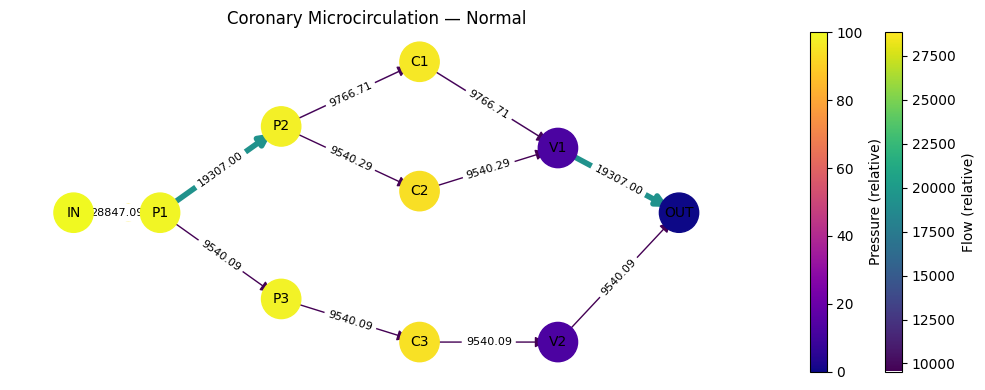

------------------------------------------------------------------------
Scenario: cholesterol_LAD
Node Pressures (mmHg):
  IN: 100.00
  P1: 99.13
  P2: 98.22
  P3: 98.33
  C1: 96.27
  C2: 60.53
  C3: 94.50
  V1: 10.27
  V2: 12.77
  OUT: 0.00
Edge Flows (μL/s):
  IN → P1: 25475.785
  P1 → P2: 15924.573
  P1 → P3: 9551.212
  P2 → C1: 10051.196
  P2 → C2: 5873.377
  P3 → C3: 9551.212
  C1 → V1: 10051.196
  C2 → V1: 5873.377
  C3 → V2: 9551.212
  V1 → OUT: 15924.573
  V2 → OUT: 9551.212
Total inflow at IN:   25475.79 μL/s
Total outflow at OUT: 25475.79 μL/s


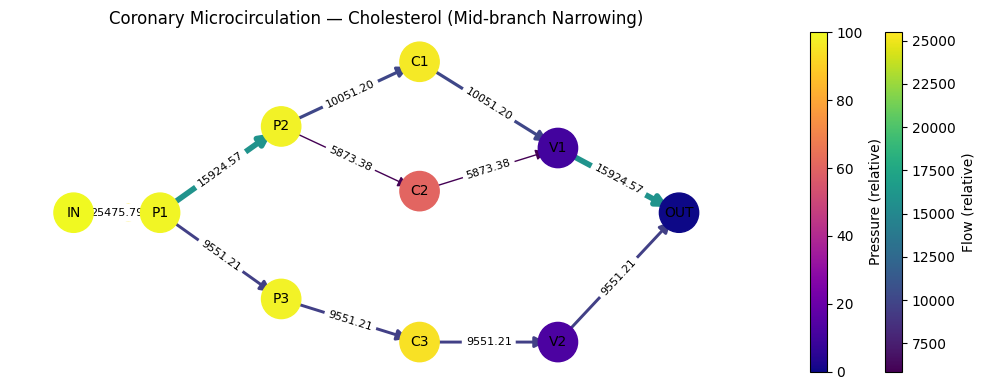

------------------------------------------------------------------------
Scenario: exercise_vasodilation
Node Pressures (mmHg):
  IN: 100.00
  P1: 98.00
  P2: 95.76
  P3: 96.37
  C1: 93.91
  C2: 92.02
  C3: 92.62
  V1: 12.18
  V2: 12.52
  OUT: 0.00
Edge Flows (μL/s):
  IN → P1: 58567.127
  P1 → P2: 39155.822
  P1 → P3: 19411.304
  P2 → C1: 19807.507
  P2 → C2: 19348.316
  P3 → C3: 19411.304
  C1 → V1: 19807.507
  C2 → V1: 19348.316
  C3 → V2: 19411.304
  V1 → OUT: 39155.822
  V2 → OUT: 19411.304
Total inflow at IN:   58567.13 μL/s
Total outflow at OUT: 58567.13 μL/s


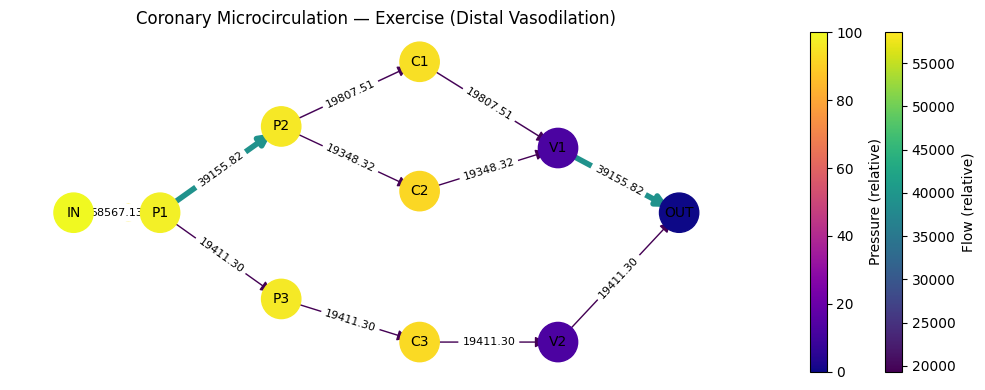

------------------------------------------------------------------------
Scenario: occlusion_distal
Node Pressures (mmHg):
  IN: 100.00
  P1: 99.34
  P2: 98.23
  P3: 99.33
  C1: 96.34
  C2: 94.39
  C3: 0.24
  V1: 12.49
  V2: 0.03
  OUT: 0.00
Edge Flows (μL/s):
  IN → P1: 19394.788
  P1 → P2: 19370.084
  P1 → P3: 24.704
  P2 → C1: 9798.621
  P2 → C2: 9571.463
  P3 → C3: 24.704
  C1 → V1: 9798.621
  C2 → V1: 9571.463
  C3 → V2: 24.704
  V1 → OUT: 19370.084
  V2 → OUT: 24.704
Total inflow at IN:   19394.79 μL/s
Total outflow at OUT: 19394.79 μL/s


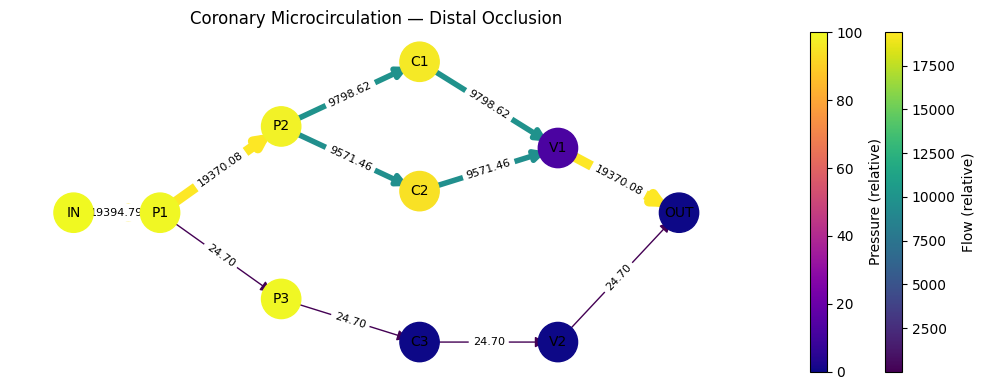

------------------------------------------------------------------------
              normal: 28847.09 μL/s
     cholesterol_LAD: 25475.79 μL/s  (-11.7% vs normal)
exercise_vasodilation: 58567.13 μL/s  (+103.0% vs normal)
    occlusion_distal: 19394.79 μL/s  (-32.8% vs normal)


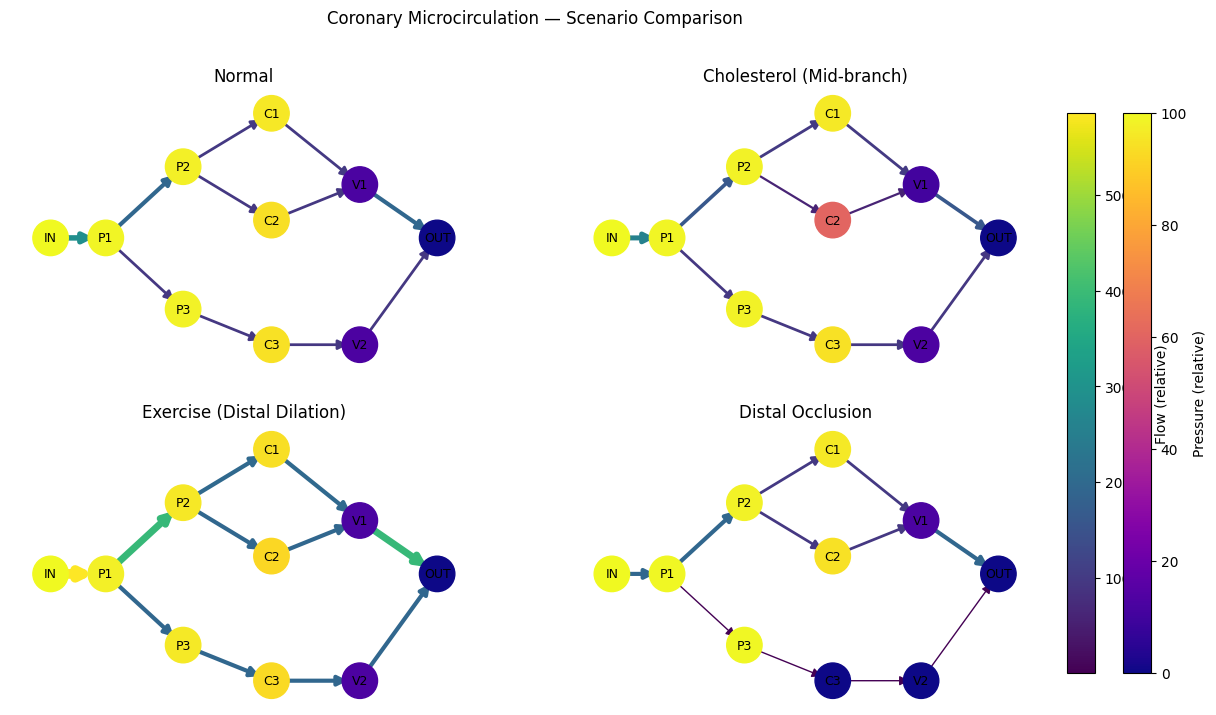

Saved figure: /content/drive/MyDrive/BloodFlowProject/outputs/scenario_comparison.png
Saved CSV: /content/drive/MyDrive/BloodFlowProject/outputs/edges_normal.csv


In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt



print()
# ====================== PART 1: simple 3-node demo ======================

# Build graph
G = nx.DiGraph()
G.add_edge("A", "B", length=1.0, radius=0.002)
G.add_edge("B", "C", length=1.0, radius=0.002)
G.add_edge("A", "C", length=1.5, radius=0.001)
#initial vessel network with radii plot
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue')
labels = {(u, v): f"r={d['radius']}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Vessel Radii (m)")
plt.show()
mu = 0.0035  #Poiseuille resistance
for u, v, d in G.edges(data=True):
    L = d['length']
    r = d['radius']
    resistance = (8 * mu * L) / (np.pi * r**4)
    d['resistance'] = resistance
#boundary conditions
pressure_boundary = {"A": 100, "C": 0}
unknown_nodes = [n for n in G.nodes if n not in pressure_boundary]
node_indices = {node: i for i, node in enumerate(unknown_nodes)}
#Kirchhoff system
n = len(unknown_nodes)
A = np.zeros((n, n))
b = np.zeros(n)
for i, node in enumerate(unknown_nodes):
    for neighbor in G.neighbors(node):
        R = G[node][neighbor]['resistance']
        if neighbor in pressure_boundary:
            b[i] += pressure_boundary[neighbor] / R
        else:
            j = node_indices[neighbor]
            A[i, j] -= 1 / R
        A[i, i] += 1 / R

    for neighbor in G.predecessors(node):
        R = G[neighbor][node]['resistance']
        if neighbor in pressure_boundary:
            b[i] += pressure_boundary[neighbor] / R
        else:
            j = node_indices[neighbor]
            A[i, j] -= 1 / R
        A[i, i] += 1 / R

#solve for unknown pressures
pressures = np.linalg.solve(A, b)
node_pressures = pressure_boundary.copy()
for node, i in node_indices.items():
    node_pressures[node] = pressures[i]
#compute flow and convert to μL/s
for u, v, d in G.edges(data=True):
    delta_p = node_pressures[u] - node_pressures[v]
    d['flow_m3_per_s'] = delta_p / d['resistance']
    d['flow'] = d['flow_m3_per_s'] * 1e9  # convert m³/s → μL/s
print("\nNode Pressures:")
for node, p in node_pressures.items():
    print(f"{node}: {p:.2f} mmHg")
print("\nFlow between nodes:")
for u, v, d in G.edges(data=True):
    print(f"{u} → {v}: {d['flow']:.6f} μL/s")
#edge label plot
edge_labels = {(u, v): f"{d['flow']:.2f}" for u, v, d in G.edges(data=True)}
pos = nx.spring_layout(G)
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1500)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Flow (μL/s) per Vessel")
plt.show()


print("---------------------additional nodes---------------------")

# ====================== PART 2: Coronary-like network w/ scenarios ======================

#constants
MMHG_TO_PA = 133.322
MU_BLOOD = 0.0035  # Pa·s
def build_coronary_graph():
    G = nx.DiGraph()

    nodes = ["IN","P1","P2","P3","C1","C2","C3","V1","V2","OUT"]
    G.add_nodes_from(nodes)

    #baseline lengths (m) and radii (m)
    G.add_edge("IN","P1", length=0.02, radius=0.0025)
    G.add_edge("P1","P2", length=0.02, radius=0.0022)
    G.add_edge("P1","P3", length=0.02, radius=0.0020)

    G.add_edge("P2","C1", length=0.006, radius=0.0012)
    G.add_edge("P2","C2", length=0.006, radius=0.0010)
    G.add_edge("P3","C3", length=0.006, radius=0.0010)

    G.add_edge("C1","V1", length=0.008, radius=0.0005)
    G.add_edge("C2","V1", length=0.008, radius=0.0005)
    G.add_edge("C3","V2", length=0.008, radius=0.0005)

    G.add_edge("V1","OUT", length=0.02, radius=0.0012)
    G.add_edge("V2","OUT", length=0.02, radius=0.0010)


    #vessel tree
    pos = {
        "IN": (0.0, 0.5),
        "P1": (0.5, 0.5),
        "P2": (1.2, 0.7),
        "P3": (1.2, 0.3),
        "C1": (2.0, 0.85),
        "C2": (2.0, 0.55),
        "C3": (2.0, 0.20),
        "V1": (2.8, 0.65),
        "V2": (2.8, 0.20),
        "OUT": (3.5, 0.5),
    }
    return G, pos



def assign_resistance(G, mu=MU_BLOOD):
    for u, v, d in G.edges(data=True):
        L, r = d["length"], d["radius"]
        d["R"] = (8 * mu * L) / (np.pi * r**4)

def solve_pressures(G, inlet="IN", outlet="OUT", Pin_mmhg=100.0, Pout_mmhg=0.0):
    bc = {inlet: Pin_mmhg, outlet: Pout_mmhg}
    unknown = [n for n in G.nodes if n not in bc]
    idx = {n:i for i,n in enumerate(unknown)}
    n = len(unknown)
    A = np.zeros((n,n))
    b = np.zeros(n)

    for i, node in enumerate(unknown):
        #out
        for nei in G.successors(node):
            R = G[node][nei]["R"]
            A[i,i] += 1.0/R
            if nei in bc:
                b[i] += bc[nei]/R
            else:
                A[i, idx[nei]] -= 1.0/R
        #in
        for nei in G.predecessors(node):
            R = G[nei][node]["R"]
            A[i,i] += 1.0/R
            if nei in bc:
                b[i] += bc[nei]/R
            else:
                A[i, idx[nei]] -= 1.0/R
    if n > 0:
        x = np.linalg.solve(A, b)
    else:
        x = []
    P = bc.copy()
    for node, i in idx.items():
        P[node] = x[i]
    return P

def compute_flows(G, P_mmhg):
    for u, v, d in G.edges(data=True):
        dP_pa = (P_mmhg[u] - P_mmhg[v]) * MMHG_TO_PA
        Q_m3s = dP_pa / d["R"]
        d["Q_m3s"] = Q_m3s
        d["Q_uLs"] = Q_m3s * 1e9  # μL/s

#modifiers
def apply_scenario(G, scenario):
    for u, v, d in G.edges(data=True):
        if "radius0" not in d:
            d["radius0"] = d["radius"]
    for _, _, d in G.edges(data=True):
        d["radius"] = d["radius0"]
    if scenario == "normal":
        pass
    elif scenario == "cholesterol_LAD":
        #50% radius reduction on P2→C2 (mid-branch stenosis)
        G["P2"]["C2"]["radius"] *= 0.5
    elif scenario == "exercise_vasodilation":
        #+20% radius on distal microvessels
        for (u,v,d) in G.edges(data=True):
            if u in {"C1","C2","C3","V1","V2"} or v in {"C1","C2","C3","V1","V2"}:
                d["radius"] *= 1.2
    elif scenario == "occlusion_distal":
        #near-occlusion on P3→C3
        G["P3"]["C3"]["radius"] *= 0.1
    else:
        raise ValueError("Unknown scenario")

#totals
def scenario_totals(G):
    total_out = sum(d["Q_uLs"] for u, v, d in G.in_edges("OUT", data=True))
    total_in = sum(d["Q_uLs"] for u, v, d in G.out_edges("IN", data=True))
    return total_in, total_out

#visualization
def plot_network(G, pos, P_mmhg, title):
    flows = np.array([abs(d["Q_uLs"]) for _,_,d in G.edges(data=True)])
    fmin, fmax = (flows.min() if flows.size else 0.0), (flows.max() if flows.size else 1.0)
    denom = (fmax - fmin) if (fmax - fmin) > 0 else 1.0
    node_press = np.array([P_mmhg[n] for n in G.nodes])
    pmin, pmax = node_press.min(), node_press.max()
    pden = (pmax - pmin) if (pmax - pmin) > 0 else 1.0
    widths = [1.0 + 6.0 * ((abs(d["Q_uLs"]) - fmin) / denom) for _,_,d in G.edges(data=True)]
    ecolors = [plt.cm.viridis((abs(d["Q_uLs"]) - fmin) / denom) for _,_,d in G.edges(data=True)]
    ncolors = [plt.cm.plasma((P_mmhg[n] - pmin) / pden) for n in G.nodes]

    fig, ax = plt.subplots(figsize=(10, 4))
    nx.draw_networkx_nodes(G, pos, node_color=ncolors, node_size=800, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=10, ax=ax)
    nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle='-|>', arrowsize=16,
                           width=widths, edge_color=ecolors, ax=ax)
    elabs = {(u,v): f"{d['Q_uLs']:.2f}" for u,v,d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=elabs, font_size=8, ax=ax)
    sm_f = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
    sm_f.set_array(flows if flows.size else np.array([0,1]))
    cbar_f = fig.colorbar(sm_f, ax=ax, fraction=0.046, pad=0.04)
    cbar_f.set_label('Flow (relative)')
    sm_p = plt.cm.ScalarMappable(cmap=plt.cm.plasma)
    sm_p.set_array(node_press)
    cbar_p = fig.colorbar(sm_p, ax=ax, fraction=0.046, pad=0.08)
    cbar_p.set_label('Pressure (relative)')


    ax.set_title(title)
    ax.set_axis_off()
    fig.tight_layout()
    plt.show()
    return fig

#running
G, pos = build_coronary_graph()
totals = {}

for scenario_name, title in [
    ("normal", "Coronary Microcirculation — Normal"),
    ("cholesterol_LAD", "Coronary Microcirculation — Cholesterol (Mid-branch Narrowing)"),
    ("exercise_vasodilation", "Coronary Microcirculation — Exercise (Distal Vasodilation)"),
    ("occlusion_distal", "Coronary Microcirculation — Distal Occlusion"),
]:
    print("------------------------------------------------------------------------")
    print(f"Scenario: {scenario_name}")
    apply_scenario(G, scenario_name)
    assign_resistance(G, MU_BLOOD)
    P = solve_pressures(G, inlet="IN", outlet="OUT", Pin_mmhg=100, Pout_mmhg=0)
    compute_flows(G, P)

    print("Node Pressures (mmHg):")
    for n in G.nodes:
        print(f"  {n}: {P[n]:.2f}")
    print("Edge Flows (μL/s):")
    for u, v, d in G.edges(data=True):
        print(f"  {u} → {v}: {d['Q_uLs']:.3f}")

    tot_in, tot_out = scenario_totals(G)
    print(f"Total inflow at IN:   {tot_in:.2f} μL/s")
    print(f"Total outflow at OUT: {tot_out:.2f} μL/s")
    totals[scenario_name] = tot_out

    _ = plot_network(G, pos, P, title)

#summary vs normal
print("------------------------------------------------------------------------")
base = totals.get("normal", None)

for k in ["normal", "cholesterol_LAD", "exercise_vasodilation", "occlusion_distal"]:
    v = totals.get(k, None)
    if v is None:
        continue
    if base is None or k == "normal":
        print(f"{k:>20}: {v:.2f} μL/s")
    else:
        delta = 100.0*(v-base)/base
        print(f"{k:>20}: {v:.2f} μL/s  ({delta:+.1f}% vs normal)")

# ====================== PART 3: 4-panel comparison (shared scales) ======================

def edge_table(G):
    rows = []
    for u, v, d in G.edges(data=True):
        rows.append({
            "u": u, "v": v,
            "length_m": d["length"],
            "radius_m": d["radius"],
            "R_Pa_s_per_m3": d["R"],
            "Q_uL_s": d["Q_uLs"]
        })
    return pd.DataFrame(rows)

#cache results
scenarios = [
    ("normal", "Normal"),
    ("cholesterol_LAD", "Cholesterol (Mid-branch)"),
    ("exercise_vasodilation", "Exercise (Distal Dilation)"),
    ("occlusion_distal", "Distal Occlusion"),
]

results = []

G_template, pos = build_coronary_graph()
for sname, title in scenarios:
    Gc = G_template.copy()
    apply_scenario(Gc, sname)
    assign_resistance(Gc, MU_BLOOD)
    P = solve_pressures(Gc, inlet="IN", outlet="OUT", Pin_mmhg=100, Pout_mmhg=0)
    compute_flows(Gc, P)
    flows = np.array([abs(d["Q_uLs"]) for _,_,d in Gc.edges(data=True)])
    results.append((sname, title, Gc, P, flows))




#global normalization
all_flows = np.concatenate([r[4] for r in results]) if results else np.array([0,1])
fmin, fmax = float(all_flows.min()), float(all_flows.max())

all_press = np.concatenate([np.array([r[3][n] for n in results[0][2].nodes]) for r in results])
pmin, pmax = float(all_press.min()), float(all_press.max())

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.ravel()

def norm(x, lo, hi):
    den = (hi-lo) if (hi>lo) else 1.0
    return (x-lo)/den

for ax, (sname, title, Gc, P, flows) in zip(axes, results):
    widths = [1.0 + 6.0*norm(abs(d["Q_uLs"]), fmin, fmax) for _,_,d in Gc.edges(data=True)]
    ecolors = [plt.cm.viridis(norm(abs(d["Q_uLs"]), fmin, fmax)) for _,_,d in Gc.edges(data=True)]
    ncolors = [plt.cm.plasma(norm(P[n], pmin, pmax)) for n in Gc.nodes]

    nx.draw_networkx_nodes(Gc, pos, node_color=ncolors, node_size=650, ax=ax)
    nx.draw_networkx_labels(Gc, pos, font_size=9, ax=ax)
    nx.draw_networkx_edges(Gc, pos, arrows=True, arrowstyle='-|>', arrowsize=14,
                           width=widths, edge_color=ecolors, ax=ax)
    ax.set_title(title)
    ax.set_axis_off()


fig.subplots_adjust(right=0.86)

sm_f = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
sm_f.set_array(all_flows)
cax_flow = fig.add_axes([0.88, 0.15, 0.02, 0.70])   #[left, bottom, width, height]
cbar_f = fig.colorbar(sm_f, cax=cax_flow)
cbar_f.set_label('Flow (relative)')

sm_p = plt.cm.ScalarMappable(cmap=plt.cm.plasma)
sm_p.set_array(all_press)
cax_press = fig.add_axes([0.92, 0.15, 0.02, 0.70])
cbar_p = fig.colorbar(sm_p, cax=cax_press)
cbar_p.set_label('Pressure (relative)')

fig.suptitle("Coronary Microcirculation — Scenario Comparison", y=0.98)
plt.show()

base_flows = {}
for u, v, d in results[0][2].edges(data=True):
    base_flows[(u, v)] = d["Q_uLs"]



# ====================== PART 4: Exports ======================

base_dir = "/content/drive/MyDrive/BloodFlowProject/outputs"
os.makedirs(base_dir, exist_ok=True)

fig_path = os.path.join(base_dir, "scenario_comparison.png")
fig.savefig(fig_path, dpi=300, bbox_inches="tight")
print("Saved figure:", fig_path)

sname, title, Gnorm, Pnorm, _ = results[0]
df_edges = edge_table(Gnorm)
csv_path = os.path.join(base_dir, f"edges_{sname}.csv")
df_edges.to_csv(csv_path, index=False)
print("Saved CSV:", csv_path)
